In [1]:
# compare mapping stats between different assemblies using the same
# mapping methods (hg38, T2T)

In [10]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [11]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [12]:
sample = 'HG00621_1'
assemblies = ['afr', 'hg38', 't2t']

## Compare mapping rate between t2t and hg38 (no thresh)

In [16]:
fq_reads_file = proc_cfg(config['lr']['fastq_n_reads_summary'], od)
t2t_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='t2t')[0], od)
hg38_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='hg38')[0], od)

In [30]:
summ_df = pd.read_csv(fq_reads_file, sep='\t')
summ_df = summ_df.loc[summ_df.dataset==sample]
summ_df.rename({'n_reads':'raw_reads'}, axis=1, inplace=True)

In [31]:
thresh = 0

assemblies = ['hg38', 't2t']
for a, f in zip(assemblies, [hg38_file, t2t_file]):
    col = f'{a}_mapped_reads'
    df = pd.read_csv(f, sep='\t')
    assert len(df.index) == len(df.read_id.unique())
    df.set_index('read_id', inplace=True)
    df = df.loc[df.mapq>=thresh]
    n = len(df.index)
    summ_df[col] = n

In [32]:
thresh = 10

assemblies = ['hg38', 't2t']
for a, f in zip(assemblies, [hg38_file, t2t_file]):
    col = f'{a}_{thresh}_mapped_reads'
    df = pd.read_csv(f, sep='\t')
    assert len(df.index) == len(df.read_id.unique())
    df.set_index('read_id', inplace=True)
    df = df.loc[df.mapq>=thresh]
    n = len(df.index)
    summ_df[col] = n

In [33]:
summ_df.head()

,dataset,raw_reads,hg38_mapped_reads,t2t_mapped_reads,hg38_10_mapped_reads,t2t_10_mapped_reads
8,HG00621_1,27257062,26328632,26329010,24386859,24364656


In [ ]:
df['hg38_perc_mapped'] = (df['hg38_mapped_reads']/df['raw_reads'])*100
df['t2t_perc_mapped'] = (df['t2t_mapped_reads']/df['raw_reads'])*100


df['hg38_10_perc_mapped'] = (df['hg38_10_mapped_reads']/df['raw_reads'])*100
df['t2t_10_perc_mapped'] = (df['t2t_10_mapped_reads']/df['raw_reads'])*100
df

## Compare mapqs between t2g and hg38

In [70]:
t2t_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='t2t')[0], od)
hg38_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='hg38')[0], od)

In [76]:
df = pd.read_csv(hg38_file, sep='\t')
df.rename({'mapq':'hg38'}, axis=1, inplace=True)
assert len(df.index) == len(df.read_id.unique())

df2 = pd.read_csv(t2t_file, sep='\t')
df2.rename({'mapq':'t2t'}, axis=1, inplace=True)
assert len(df2.index) == len(df2.read_id.unique())

,read_id,mapq,assembly
0,656f1899-097a-4d0e-a956-eb0f9dd040e2:0,20,hg38
1,39c58a50-2e13-4bd7-9484-008563de3916:0,27,hg38
2,c6e18f10-2b77-4112-a2ee-7157c0a8c8a0:0,27,hg38
3,8c3d82da-fc2c-4667-b5d3-82098f206e7f:0,0,hg38
4,28327cc7-7153-4190-8087-560d3ffccbab:0,0,hg38


In [91]:
init_plot_settings(aspect='square')
# sns.boxplot(df, y='mapq', x='assembly') not useful lol

In [81]:
# compute % of alignments that are 60
df['max_mapq'] = df.mapq>=60
df = df[['read_id', 'assembly', 'max_mapq']].groupby(['assembly', 'max_mapq']).nunique().reset_index()

In [85]:
df['total'] = df.groupby('assembly')['read_id'].transform('sum')
df['perc'] = (df.read_id/df.total)*100

In [86]:
df.head()

,assembly,max_mapq,read_id,total,perc
0,hg38,False,6416479,26328632,24.370727
1,hg38,True,19912153,26328632,75.629273
2,t2t,False,6321409,26329010,24.009292
3,t2t,True,20007601,26329010,75.990708


## Compare mapqs between t2g and hg38

In [98]:
t2t_file = proc_cfg(expand(config['lr']['map']['bam_query_covs'],
                          sample=sample,
                          assembly='t2t')[0], od)
hg38_file = proc_cfg(expand(config['lr']['map']['bam_query_covs'],
                          sample=sample,
                          assembly='hg38')[0], od)

In [99]:
df = pd.read_csv(hg38_file, sep='\t')
df['assembly'] = 'hg38'
assert len(df.index) == len(df.read_id.unique())
df2 = pd.read_csv(t2t_file, sep='\t')
df2['assembly'] = 't2t'
assert len(df2.index) == len(df2.read_id.unique())
df = pd.concat([df, df2], axis=0)
df.head()

,read_id,query_cov,read_len,chr,assembly
0,656f1899-097a-4d0e-a956-eb0f9dd040e2:0,0.981723,383.0,chr1,hg38
1,39c58a50-2e13-4bd7-9484-008563de3916:0,0.991903,1729.0,chr1,hg38
2,c6e18f10-2b77-4112-a2ee-7157c0a8c8a0:0,0.999430,1753.0,chr1,hg38
3,8c3d82da-fc2c-4667-b5d3-82098f206e7f:0,0.934783,92.0,chr1,hg38
4,28327cc7-7153-4190-8087-560d3ffccbab:0,1.000000,84.0,chr1,hg38


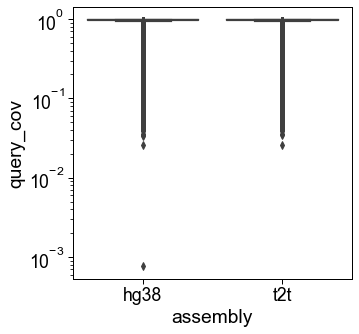

In [94]:
init_plot_settings(aspect='square')
sns.boxplot(df, y='query_cov', x='assembly') 
plt.yscale('log')

In [100]:
# compute % of alignments that >90%
df['high_qcov'] = df.query_cov>=.90
df = df[['read_id', 'assembly', 'high_qcov']].groupby(['assembly', 'high_qcov']).nunique().reset_index()

In [101]:
df['total'] = df.groupby('assembly')['read_id'].transform('sum')
df['perc'] = (df.read_id/df.total)*100
df.head()

,assembly,high_qcov,read_id,total,perc
0,hg38,False,1309514,26328632,4.973726
1,hg38,True,25019118,26328632,95.026274
2,t2t,False,1306006,26329010,4.960331
3,t2t,True,25023004,26329010,95.039669


## Compute delta between qcov for the same reads

In [102]:
t2t_file = proc_cfg(expand(config['lr']['map']['bam_query_covs'],
                          sample=sample,
                          assembly='t2t')[0], od)
hg38_file = proc_cfg(expand(config['lr']['map']['bam_query_covs'],
                          sample=sample,
                          assembly='hg38')[0], od)

In [103]:
df = pd.read_csv(hg38_file, sep='\t')
df['assembly'] = 'hg38'
assert len(df.index) == len(df.read_id.unique())
df2 = pd.read_csv(t2t_file, sep='\t')
df2['assembly'] = 't2t'
assert len(df2.index) == len(df2.read_id.unique())
df.head()

,read_id,query_cov,read_len,chr,assembly
0,656f1899-097a-4d0e-a956-eb0f9dd040e2:0,0.981723,383.0,chr1,hg38
1,39c58a50-2e13-4bd7-9484-008563de3916:0,0.991903,1729.0,chr1,hg38
2,c6e18f10-2b77-4112-a2ee-7157c0a8c8a0:0,0.999430,1753.0,chr1,hg38
3,8c3d82da-fc2c-4667-b5d3-82098f206e7f:0,0.934783,92.0,chr1,hg38
4,28327cc7-7153-4190-8087-560d3ffccbab:0,1.000000,84.0,chr1,hg38


In [ ]:
df.drop(['assembly', 'read_len', 'chr'], axis=1, inplace=True)
df2.drop(['assembly', 'read_len', 'chr'], axis=1, inplace=True)

In [107]:
# merge on read id
df = df.merge(df2, on='read_id', how='outer', suffixes=('_hg38', '_t2t'))

In [ ]:
# # label nulls in one or the other
# # makybe just do this on mn5
# df['category'] = 'shared'
# df.loc[(df.query_cov_t2t.notnull())&\
#        (df.query_cov_hg38.isnull()), 'shared'] = 't2t_only'
# df.loc[(df.query_cov_t2t.isnull())&\
#        (df.query_cov_hg38.notnull()), 'shared'] = 'hg38_only'

# g = sns.jointplot(df, x='query_cov_hg38', 
#                       y='query_cov_t2t',
#                       hue='category')
    
# # Get the axis object
# ax = g.ax_joint

# # Plot the x = y line
# lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
# ax.plot(lims, lims, ':k')  # ':k' is a black dashed line

# # Set the same limits for x and y axes
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# # Show plot
# plt.show()

In [112]:
df['qcov_diff'] = df['query_cov_t2t']-df['query_cov_hg38']

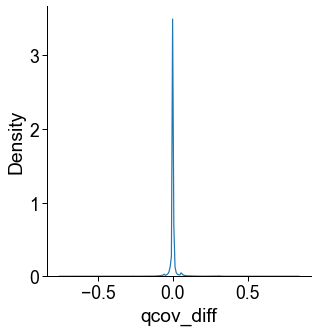

In [113]:
sns.displot(df, kind='kde', x='qcov_diff')
# negative means  higher in hg38; positive means higher in t2t

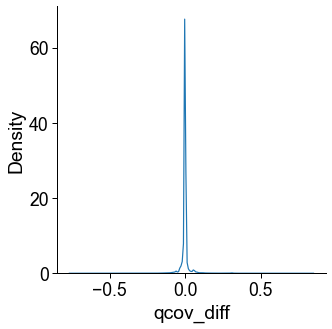

In [115]:
# with removing the 0 diffs
temp = df.loc[df.qcov_diff!=0]
sns.displot(temp, kind='kde', x='qcov_diff')
# negative means  higher in hg38; positive means higher in t2t

In [111]:
# number that are higher in hg38 vs. t2t and vice versa
# from reads that aligned in both
temp = df.loc[(df.query_cov_hg38.notnull())&\
              (df.query_cov_t2t.notnull())]
n = len(temp.loc[temp.query_cov_hg38>temp.query_cov_t2t].index)
print(f'{n} reads have higher qcov in hg38 than t2t')

n = len(temp.loc[temp.query_cov_hg38<temp.query_cov_t2t].index)
print(f'{n} reads have higher qcov in t2t than hg38')

591281 reads have higher qcov in hg38 than t2t
508560 reads have higher qcov in t2t than hg38


In [116]:
# number of reads that didn't align in hg38
n = len(df.loc[(df.query_cov_t2t.notnull())&\
               (df.query_cov_hg38.isnull())].index)
print(f'{n} reads mapped in t2t that didnt in hg38')


1931 reads mapped in t2t that didnt in hg38


In [117]:
# number of reads that didn't align in t2t
n = len(df.loc[(df.query_cov_t2t.isnull())&\
               (df.query_cov_hg38.notnull())].index)
print(f'{n} reads mapped in hg38 that didnt in t2t')

1553 reads mapped in hg38 that didnt in t2t


## Compute delta between mapq for the same reads

In [123]:
t2t_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='t2t')[0], od)
hg38_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='hg38')[0], od)

In [124]:
df = pd.read_csv(hg38_file, sep='\t')
df['assembly'] = 'hg38'
assert len(df.index) == len(df.read_id.unique())
df2 = pd.read_csv(t2t_file, sep='\t')
df2['assembly'] = 't2t'
assert len(df2.index) == len(df2.read_id.unique())
df.head()

,read_id,mapq,assembly
0,656f1899-097a-4d0e-a956-eb0f9dd040e2:0,20,hg38
1,39c58a50-2e13-4bd7-9484-008563de3916:0,27,hg38
2,c6e18f10-2b77-4112-a2ee-7157c0a8c8a0:0,27,hg38
3,8c3d82da-fc2c-4667-b5d3-82098f206e7f:0,0,hg38
4,28327cc7-7153-4190-8087-560d3ffccbab:0,0,hg38


In [126]:
df.drop(['assembly'], axis=1, inplace=True)
df2.drop(['assembly'], axis=1, inplace=True)

In [127]:
# merge on read id
df = df.merge(df2, on='read_id', how='outer', suffixes=('_hg38', '_t2t'))

In [128]:
# # label nulls in one or the other
# df['category'] = 'shared'
# df.loc[(df.mapq_t2t.notnull())&\
#        (df.mapq_hg38.isnull()), 'shared'] = 't2t_only'
# df.loc[(df.mapq_t2t.isnull())&\
#        (df.mapq_hg38.notnull()), 'shared'] = 'hg38_only'

# g = sns.jointplot(df, x='mapq_hg38', 
#                       y='mapq_t2t',
#                       hue='category')
    
# # Get the axis object
# ax = g.ax_joint

# # Plot the x = y line
# lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
# ax.plot(lims, lims, ':k')  # ':k' is a black dashed line

# # Set the same limits for x and y axes
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# # Show plot
# plt.show()

In [129]:
df['mapq_diff'] = df['mapq_t2t']-df['mapq_hg38']

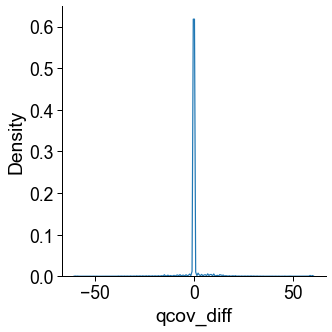

In [130]:
sns.displot(df, kind='kde', x='mapq_diff')
# negative means  higher in hg38; positive means higher in t2t

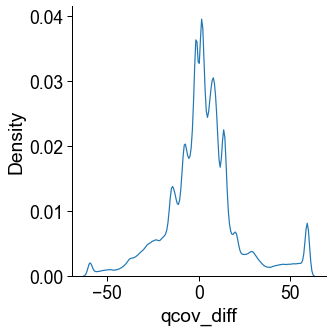

In [131]:
# with removing the 0 diffs
temp = df.loc[df.qcov_diff!=0]
sns.displot(temp, kind='kde', x='qcov_diff')
# negative means  higher in hg38; positive means higher in t2t

In [132]:
# number that are higher in hg38 vs. t2t and vice versa
# from reads that aligned in both
temp = df.loc[(df.mapq_hg38.notnull())&\
              (df.mapq_t2t.notnull())]
n = len(temp.loc[temp.mapq_hg38>temp.mapq_t2t].index)
print(f'{n} reads have higher qcov in hg38 than t2t')

n = len(temp.loc[temp.mapq_hg38<temp.mapq_t2t].index)
print(f'{n} reads have higher qcov in t2t than hg38')

1286783 reads have higher qcov in hg38 than t2t
1631409 reads have higher qcov in t2t than hg38


In [133]:
# number of reads that didn't align in hg38
n = len(df.loc[(df.mapq_t2t.notnull())&\
               (df.mapq_hg38.isnull())].index)
print(f'{n} reads mapped in t2t that didnt in hg38')


1931 reads mapped in t2t that didnt in hg38


In [134]:
# number of reads that didn't align in t2t
n = len(df.loc[(df.mapq_t2t.isnull())&\
               (df.mapq_hg38.notnull())].index)
print(f'{n} reads mapped in hg38 that didnt in t2t')

1553 reads mapped in hg38 that didnt in t2t
